This notebook aims to show how we cluster the lightning data and save into hull.

In [33]:
import math
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import proplot as pplt
from satpy import Scene
import metpy.calc as mpcalc
from metpy.units import units
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

## Read TROPOMI data

In [20]:
scn = Scene(glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190627T18*.nc'), reader='tropomi_l2')
vnames = ['time_utc', 'nitrogendioxide_tropospheric_column']

scn.load(vnames)

# get the mean overpass time for the Arctic
t_overpass = pd.to_datetime(scn['time_utc'].where(scn['nitrogendioxide_tropospheric_column'].latitude.mean('x') >= 70, drop=True)).mean()


Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure


## Read lightning data

In [23]:
df = pd.read_csv('../data/gld360/gld360_arctic_20190627.csv')

# pick the interesting region and time
df = df[(df['latitude']>75)  & (df['latitude']<88)]

# get lightning dots during the several hours before the mean overpass time
df['timestamp'] =  pd.to_datetime(df['timestamp'], utc=True)
delta = df['timestamp'] - t_overpass
df['delta'] = delta.dt.total_seconds()/60

df = df.set_index('timestamp')
df = df['2019-06-27 08:00':'2019-06-27 20:00']


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

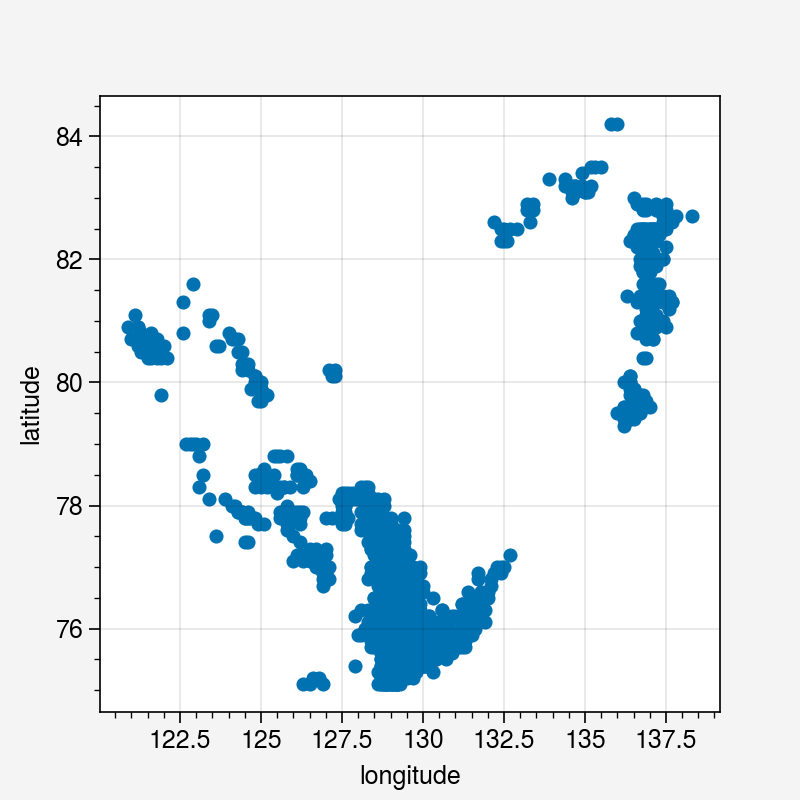

In [24]:
df.plot.scatter(x='longitude', y='latitude')


## Cluster the observed lightning

In [13]:
def get_large_hull(hulls, stretchCoef=1.5):
    '''Get a larger hull in case some fires are nearby'''
    large_hull = []
    for hull in hulls:
        stretchCoef = stretchCoef
        pointsStretched = hull.points[hull.vertices]*stretchCoef # test
        #pointsStretched = bufferPoints(hull.points, stretchCoef, n=100) # true
        # ring = LinearRing(list(zip(pointsStretched[:, 1], pointsStretched[:, 0])))
        large_hull.append(pointsStretched[:, [1,0]])

    return large_hull

def get_cluster(df_lightning):
    '''Get the cluster of lightning points
    
    Ref: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

    '''
    coords = df_lightning[['latitude', 'longitude']].values
    kms_per_radian = 6371.0088

    # search for 40km around each lightning dots
    epsilon = 40/kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    df_cluster = pd.DataFrame({'time': df_lightning['timestamp'].values,
                               'longitude': df_lightning['longitude'].values,
                               'latitude': df_lightning['latitude'].values,
                               #'type': df_lightning['type'].values,
                               #'peakcurrent': df_lightning['peakcurrent'].values,
                               'delta': df_lightning['delta'].values,
                               'label': cluster_labels})

    # drop noise data (-1)
    df_cluster = df_cluster[df_cluster.label != -1] 

    # more than 20 points
    v = df_cluster.label.value_counts()
    df_cluster = df_cluster[df_cluster.label.isin(v.index[v.gt(20)])]
    cluster_labels = list(set(df_cluster['label']))
    # num_clusters = len(cluster_labels)

    hulls = []

    for label in cluster_labels:
        dfq = df_cluster[df_cluster['label']==label]
        Y = np.array(dfq[['longitude', 'latitude']])
        hull = ConvexHull(Y)
        hulls.append(hull)

    large_hulls = get_large_hull(hulls)

    return df_cluster, cluster_labels, large_hulls


In [26]:
df_cluster, cluster_labels, hulls = get_cluster(df.reset_index())

## Predict the transported lightning air using era5 data

In [34]:
ds_era5 = xr.open_dataset('../data/era5/era5_201906.nc')

In [35]:
def predict_loc(lon, lat, wdir, wspd, wdelta):
    # https://stackoverflow.com/a/7835325/7347925
    lon, lat = np.deg2rad(lon), np.deg2rad(lat)
    R = 6378.1  # Radius of the Earth
    brng = np.deg2rad(wdir)  # Bearing is radians.
    d = wspd*wdelta/1e3  # Distance in km
    # brng = np.deg2rad(data['wdir'])  # Bearing is radians.
    # d = data['wspd']*data['wdelta']/1e3  # Distance in km

    lat2 = math.asin(math.sin(lat)*math.cos(d/R) + math.cos(lat)*math.sin(d/R)*math.cos(brng))

    lon2 = lon + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat),
                math.cos(d/R)-math.sin(lat)*math.sin(lat2))

    lat2 = np.rad2deg(lat2)
    lon2 = np.rad2deg(lon2)

    return lon2, lat2

In [36]:
def pred_cluster(df_cluster, t_overpass, ds_era5, wind_levels):
    for level in wind_levels:

        lons, lats = [], []
        # df.rename(columns={'timestamp': 'time'}, inplace=True)

        for _, row in df_cluster.iterrows():
            times = np.concatenate(([row.time.to_pydatetime().replace(tzinfo=None)],
                                pd.date_range(row.time.ceil('h').replace(tzinfo=None),
                                                t_overpass.floor('h').replace(tzinfo=None), freq='H').to_pydatetime(),
                                [t_overpass.replace(tzinfo=None).to_pydatetime()]
            ))

            delta_wind = [t.total_seconds() for t in np.diff(times)]

            lat, lon = row.latitude, row.longitude

            for t_index, time in enumerate(times[:-1]):
                data = ds_era5.interp(time=time, longitude=lon, latitude=lat, level=level)

                # if there's nan value then just skip it.
                # This situation sometimes happen at the high level (> 250 hPa)
                if np.isnan(data['u']) or np.isnan(data['v']):
                    continue

                data['wspd'] = mpcalc.wind_speed(data['u'] * units.meters / units.second,
                                                data['v'] * units.meters / units.second).rename('wspd')
                data['wdir'] = mpcalc.wind_direction(data['u'] * units.meters / units.second,
                                                        data['v'] * units.meters / units.second,
                                                        convention='to').rename('wdir')

                lon, lat = predict_loc(lon, lat, data['wdir'].metpy.dequantify(),
                                    data['wspd'].metpy.dequantify(), delta_wind[t_index])
            lons.append(lon)
            lats.append(lat)

            # with Pool(max_workers=int(cfg['num_cpus'])) as pool:
            #     pred_lons, pred_lats = zip(*pool.map(functools.partial(pred_cluster_chunk, t_overpass=t_overpass,
            #                                                             ds_era5=ds_era5, level=level),
            #                                          chunk_df))
            #     pred_lons = sum([*pred_lons], []) 
            #     pred_lats = sum([*pred_lats], []) 

        df_cluster[f'longitude_pred_{level}'] = lons
        df_cluster[f'latitude_pred_{level}'] = lats

    return df_cluster


In [37]:
wind_levels = np.arange(700, 100, -200)  # pressure levels used to calculate the location of transported LNO2 air parcel

df_cluster_pred = pred_cluster(df_cluster, t_overpass, ds_era5, wind_levels)

/tmp/ipykernel_52987/3087571730.py:3: UserWarning: Discarding nonzero nanoseconds in conversion
  df_cluster_pred = pred_cluster(df_cluster, t_overpass, ds_era5, wind_levels)


In [38]:
df_cluster_pred

,time,longitude,latitude,delta,label,longitude_pred_700,latitude_pred_700,longitude_pred_500,latitude_pred_500,longitude_pred_300,latitude_pred_300
0,2019-06-27 08:00:00,136.3,79.5,-694.656355,0,136.273963,84.166116,138.399355,83.131946,133.913518,82.820653
1,2019-06-27 08:00:00,136.3,79.4,-694.656355,0,135.416293,84.097025,138.534878,82.999793,134.644994,82.796615
2,2019-06-27 08:00:00,136.4,79.4,-694.656355,0,135.437453,84.075560,138.677139,82.979230,134.645984,82.821136
3,2019-06-27 08:00:00,136.2,79.3,-694.656355,0,134.340990,84.057007,138.501231,82.892072,135.407434,82.736985
4,2019-06-27 08:00:00,136.2,79.4,-694.656355,0,135.397850,84.118122,138.392717,83.020452,134.646462,82.771535
...,...,...,...,...,...,...,...,...,...,...,...
1675,2019-06-27 19:10:00,124.1,80.7,-24.656355,3,123.829743,80.919856,123.655250,80.923667,123.612679,80.872540
1676,2019-06-27 19:20:00,124.0,80.8,-14.656355,3,123.835922,80.930209,123.731294,80.933159,123.704842,80.903333
1677,2019-06-27 19:40:00,123.4,81.1,5.343645,3,123.464958,81.052451,123.506510,81.050402,123.516748,81.061722
1678,2019-06-27 19:40:00,123.4,81.0,5.343645,3,123.460909,80.952806,123.504243,80.950548,123.515405,80.961067


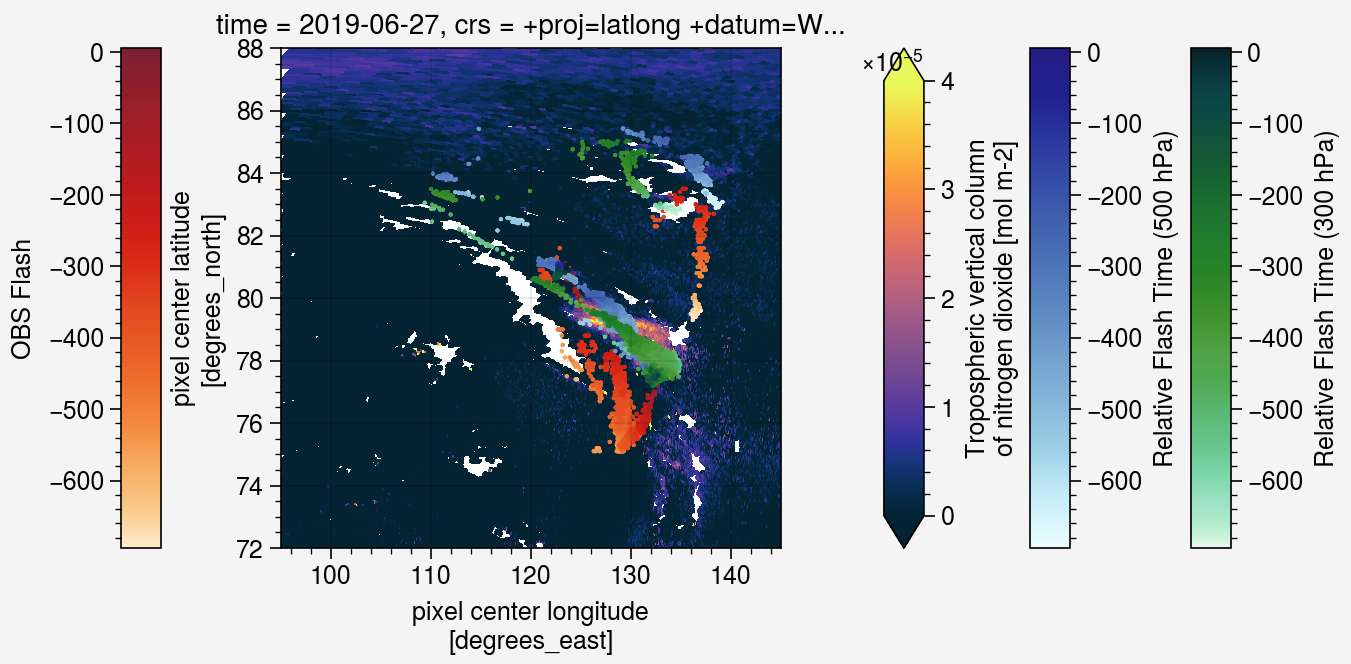

In [87]:
fig, axs = pplt.subplots()

lon = scn['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = scn['nitrogendioxide_tropospheric_column'].coords['latitude']

lon_min = 95; lon_max = 145
lat_min = 72; lat_max = 88

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(x='longitude', y='latitude',
cmap='Thermal', vmin=0, vmax=4e-5, discrete=False)

s = axs.scatter(df_cluster_pred['longitude'], df_cluster_pred['latitude'],
            marker="$\u25EF$", cmap='Reds2',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='l', label=f'OBS Flash')

# s = axs.scatter(df_cluster_pred['longitude_pred_700'], df_cluster_pred['latitude_pred_700'],
#             marker="$\u25EF$", cmap='Blues2',
#             c=df_cluster_pred['delta'], s=1)
# axs.colorbar(s, loc='r', label=f'Relative Flash Time (700 hPa)')

s = axs.scatter(df_cluster_pred['longitude_pred_500'], df_cluster_pred['latitude_pred_500'],
            marker="$\u25EF$", cmap='Blues2',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='r', label=f'Relative Flash Time (500 hPa)')

s = axs.scatter(df_cluster_pred['longitude_pred_300'], df_cluster_pred['latitude_pred_300'],
            marker="$\u25EF$", cmap='Greens2',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='r', label=f'Relative Flash Time (300 hPa)')

axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max))

In [54]:
lightning_mask = xr.full_like(scn['nitrogendioxide_tropospheric_column'], 0, dtype=int).load().copy()

In [55]:
def in_hull(p, hull):
    """ 
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed

    https://stackoverflow.com/a/16898636/7347925
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [56]:
def concat_pred(ds):
    '''Concatenate predicted lon and lat by pressure level'''
    # get the DataArray names of predicted lon and lat
    lon_names = [var for var in ds.data_vars if 'longitude_pred' in var]
    lat_names = [var for var in ds.data_vars if 'latitude_pred' in var]
    levels = [int(name.split('_')[-1]) for name in lon_names]

    # concatenate into one array
    ds['longitude_pred'] = ds[lon_names].to_array(dim='lon_level', name='longitude_pred').assign_coords(lon_level=levels).rename({'lon_level':'level'})
    ds['latitude_pred'] = ds[lat_names].to_array(dim='lat_level', name='longitude_pred').assign_coords(lat_level=levels).rename({'lat_level':'level'})
    ds.coords['level'].attrs['units'] = 'hPa'

    # add description and units
    ds['longitude_pred'].attrs['description'] = 'Longitude of lightning at different pressure levels predicted by ERA5 data'
    ds['latitude_pred'].attrs['description'] = 'Latitude of lightning at different pressure levels predicted by ERA5 data'

    # drop useless variables
    ds = ds.drop_vars(lon_names+lat_names)

    return ds


In [57]:
def convert_cluster(scn, df, lightning_mask, kind='clean'):
    '''Convert the lightning cluster DataFrame to Dataset which has the same shape of NO2'''
    # rename the label
    df = df.rename(columns={'label':'lightning_label'})
    # set label as index which is the coordinate of xarray Dataset
    df.set_index(['lightning_label'], inplace=True)
    # convert to Dataset
    ds = concat_pred(df.to_xarray())

    # get the pixel center points
    pixel_points = np.vstack((scn['nitrogendioxide_tropospheric_column'].longitude.stack(z=('x', 'y')),
                              scn['nitrogendioxide_tropospheric_column'].latitude.stack(z=('x', 'y')))
                              ).T 

    labels = list(set(ds.lightning_label.values))

    for index, label in enumerate(labels):
        # iterate each label and update the mask
        dfq = ds.sel(lightning_label=label)
        lon_lat = dfq[['longitude_pred', 'latitude_pred']].stack(all=("level", "lightning_label"))
        lightning_points = lon_lat.to_array().transpose('all', ...)
        # hull = ConvexHull(lightning_points)

        mask = in_hull(pixel_points, lightning_points).reshape(scn['nitrogendioxide_tropospheric_column'].shape, order='F')

        # get the overplapped label
        overlapped_label = np.delete(np.unique(lightning_mask.where(xr.DataArray(mask, dims=['y', 'x']), 0)), 0)

        if len(overlapped_label) == 0:
            if kind == 'clean':
                # clean lightning label: 1, 2, ....
                lightning_mask = xr.where(mask, index+1, lightning_mask)
            elif kind == 'polluted':
                # polluted lightning label: -1, -2, ....
                lightning_mask = xr.where(mask, -index-1, lightning_mask)
        elif len(overlapped_label) == 1:
            # set to the only overlapped value
            if kind == 'clean':
                lightning_mask = xr.where(mask, overlapped_label[0], lightning_mask)
            elif kind == 'polluted':
                lightning_mask = xr.where(mask, overlapped_label[0], lightning_mask)
        else:
            # get the minimum label
            min_label = overlapped_label.min()
            # set the mask where lightning happens to minimum label
            lightning_mask = xr.where(mask, min_label, lightning_mask)
            # update mask with the rest labels
            for rest_label in np.delete(overlapped_label, np.where(overlapped_label == min_label)):
                lightning_mask = lightning_mask.where(lightning_mask==rest_label, min_label)

    return ds, lightning_mask.rename('lightning_mask')


In [58]:
clean_cluster, clean_lightning_mask = convert_cluster(scn, df_cluster_pred, lightning_mask, 'clean')

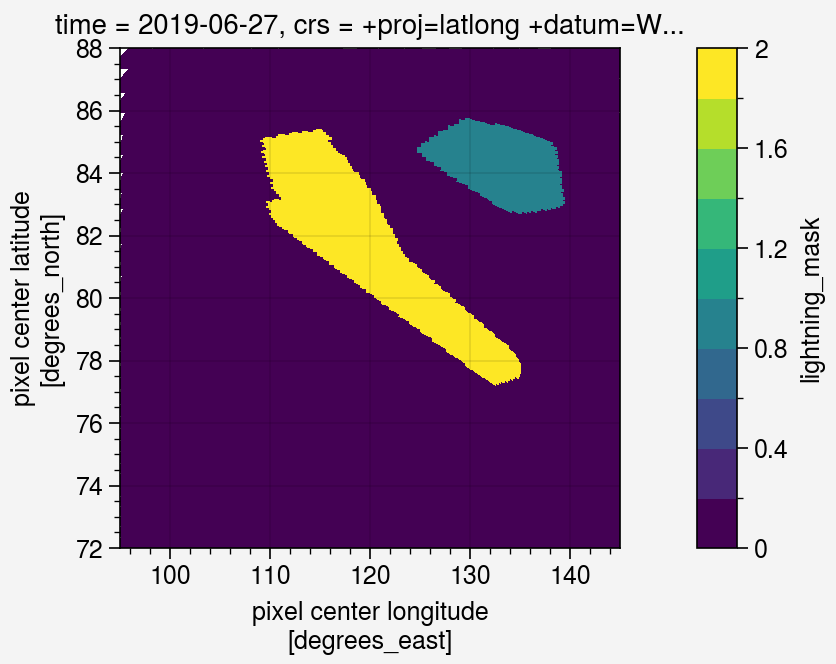

In [79]:
fig, axs = pplt.subplots()

lon = scn['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = scn['nitrogendioxide_tropospheric_column'].coords['latitude']

lon_min = 95; lon_max = 145
lat_min = 72; lat_max = 88

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
clean_lightning_mask.where(mask, drop=True).plot(x='longitude', y='latitude')#,
# cmap='Thermal', vmin=0, vmax=4e-5, discrete=False)


axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max))

In [75]:
ds_output = xr.open_dataset(glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190627T18*nc')[0], group='S5P').isel(time=0)\
                [['nitrogendioxide_tropospheric_column',
                  'nitrogendioxide_segmentation', 'lightning_mask']]

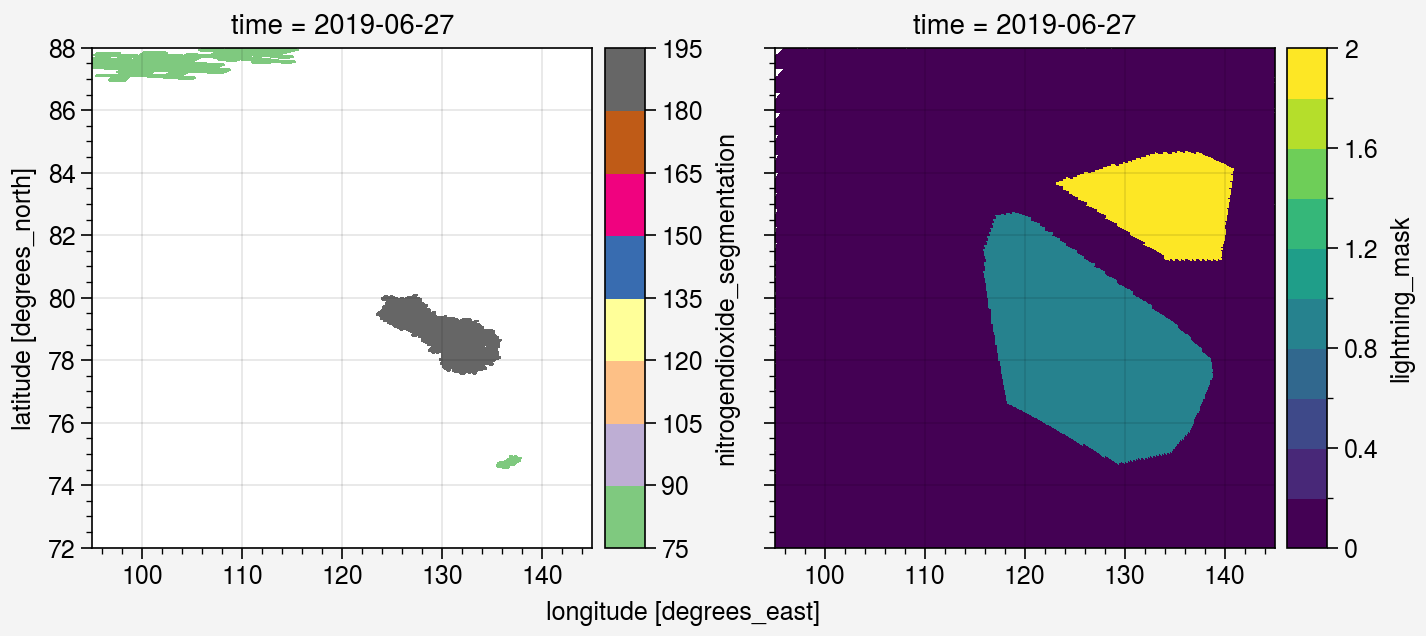

In [78]:
fig, axs = pplt.subplots(ncols=2)

lon = ds_output['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = ds_output['nitrogendioxide_tropospheric_column'].coords['latitude']

lon_min = 95; lon_max = 145
lat_min = 72; lat_max = 88

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)

segmentation = ds_output['nitrogendioxide_segmentation'].where(mask, drop=True)

segmentation.where(segmentation>0).plot(x='longitude', y='latitude', ax=axs[0], cmap='Accent')
# vmin=segmentation.where(segmentation>0).quantile(0.1), ax=axs[0])

ds_output['lightning_mask'].where(mask, drop=True).plot(x='longitude', y='latitude',ax=axs[1])


axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max))